# Team 5: Q-Vectors and Q-Vector Convergence

## 1) Imports

In [1]:
import sys
sys.path.append('/home/decker/lab433')

from datetime import datetime

from synoptic import MODEL, display_grids

import xarray as xr
from metpy.units import units
from metpy.constants import dry_air_gas_constant as R
from metpy.io import GempakGrid
import metpy.calc as mpcalc
from metpy.plots import ArrowPlot, BarbPlot, FilledContourPlot, MapPanel, PanelContainer

## 2) Get the data

In [2]:
gem_file_name = MODEL + 'nam/24101612_nam211.gem'
gem_file = GempakGrid(gem_file_name)

In [3]:
#list_of_grids = gem_file.gdinfo()
#display_grids(list_of_grids)

In [4]:
plot_time = datetime(2024, 10, 16, 18)
pres = 300
pres = pres * units('hPa')
ht = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level=pres.m)[0]
ht = ht * units('m')
temp = gem_file.gdxarray(parameter='TMPK', date_time=plot_time, level=pres.m)[0]
temp = temp * units('K')

In [5]:
smoothing = 16
ht = mpcalc.smooth_gaussian(ht, smoothing)
temp = mpcalc.smooth_gaussian(temp, smoothing)

## 3) Calculations

In [6]:
ug, vg = mpcalc.geostrophic_wind(ht)

In [7]:
Q_i, Q_j = mpcalc.q_vector(ug, vg, temp, pres)
Q_i = Q_i.rename('i')
Q_j = Q_j.rename('j')

In [8]:
Q_vector = xr.merge([Q_i, Q_j])

In [9]:
Q_vector

Magnitude,[[[[-6.1174753181527885e-15 -7.969967670968429e-15 -1.0317711595321675e-14 ... 5.841425754454639e-15 1.9444426008464494e-15 6.477287619981449e-16] [6.7549066657971855e-15 -1.7444995799781134e-15 -1.2711631638120824e-14 ... 1.2261017004387464e-14 5.409568846743664e-15 3.0184521485498098e-15] [3.042249335451767e-14 1.4836802461721122e-14 -5.3610286979566e-15 ... 1.7642796839629086e-14 1.0243877583264601e-14 7.86249749762482e-15] ... [-6.3107351886882e-12 -6.38533172338881e-12 -6.390836074487512e-12 ... 9.644247204042713e-14 1.5468042941537467e-13 9.373420848290925e-14] [-3.65429444619888e-12 -3.761368559554463e-12 -3.843346219105453e-12 ... -8.399163905644568e-14 -2.300962475168319e-14 -4.749500744154583e-14] [-1.319525831614588e-12 -1.357270677374897e-12 -1.3777209619423953e-12 ... -8.630973994251892e-14 -3.834407237800274e-14 -3.0197995079043826e-14]]]]
Units,meter2/(kilogram second)
Magnitude,[[[[4.968123365895119e-15 1.3413777647538747e-14 1.537717162706744e-14 ... -1.8793091842125428e-14 -5.3146702375336524e-15 -4.334431525448229e-17] [4.979346566973467e-15 1.4210049915602191e-14 1.905031619341863e-14 ... -1.943822824515634e-14 -7.585254057344543e-15 -1.0835561289869532e-15] [5.346606915366867e-15 1.563938250758309e-14 2.3298016110016545e-14 ... -2.1276579755153348e-14 -1.131425732029243e-14 -2.565458885966133e-15] ... [-3.451609121938841e-13 -6.56411483903898e-13 -7.344537188546767e-13 ... 6.47886580289108e-13 5.051160881331091e-13 1.9455275888352071e-13] [-5.716521692958698e-13 -1.1876055032301985e-12 -1.454685835561818e-12 ... 9.75077972160239e-13 7.084969812312425e-13 2.6557163094340163e-13] [-7.131183425366187e-13 -1.5135118216958655e-12 -1.8906608382884037e-12 ... 1.282585803384159e-12 9.149045116735988e-13 3.491155210021034e-13]]]]
Units,meter2/(kilogram second)


In [10]:
F = -2 * (mpcalc.divergence(Q_i, Q_j))

## 4) Plot it

You can try plotting Q-vectors as arrows instead of wind barbs if you'd like!

In [11]:
fill = FilledContourPlot()
fill.data = F
fill.time = plot_time
fill.contours = range(-36, 36, 1)
fill.scale = 5e17
fill.colormap = 'bwr'
fill.colorbar = 'horizontal'
#fill.plot_units = 'degC'

In [12]:
barbs = BarbPlot()
barbs.data = Q_vector
barbs.scale = 2e13
barbs.time = plot_time
barbs.field = ['i', 'j']
barbs.earth_relative = False
barbs.skip = (3, 3)
#barbs.plot_units = 'knot'

In [13]:
panel = MapPanel()
panel.area = [-120, -74, 22, 55]
panel.projection = 'lcc'
panel.layers = ['states', 'coastline', 'borders']
panel.title = f'Q Vectors and Forcing Term at {plot_time}'
panel.plots = [fill, barbs]

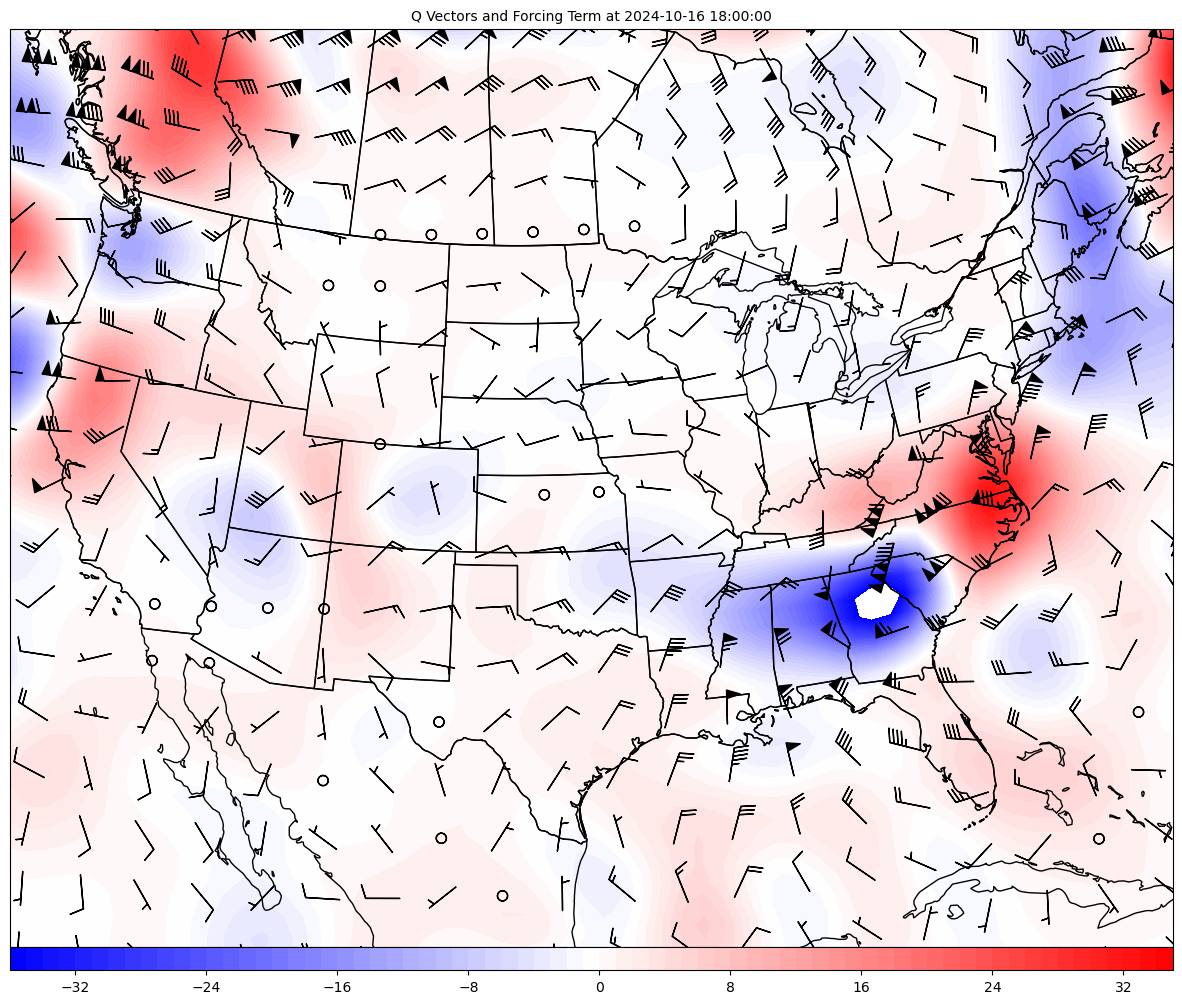

In [14]:
pc = PanelContainer()
pc.size = (15, 15)
pc.panels = [panel]
pc.show()